In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# create folder to save results
import os
if not os.path.exists('results_1d_beam'):
    os.makedirs('results_1d_beam')


We consider a 1D beam of length 3L, with a fixed support at x = 0 and a pin at x = 2L.
The beam is loaded with a force P at x = 3L.
The beam is made of a material with Young's modulus E and moment of inertia I.

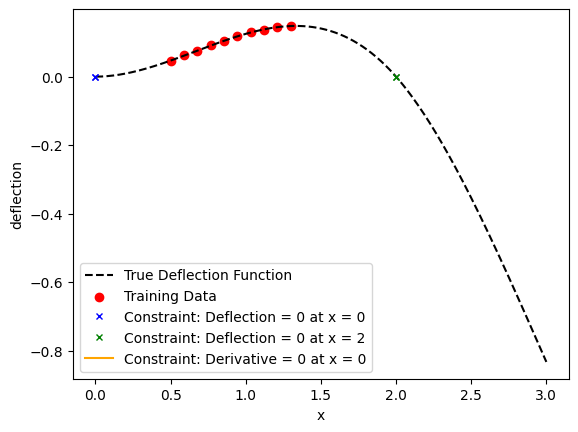

In [3]:
def deflection(x):
    # Young's modulus of steel 
    E = 200e9
    # length of the beam 
    L = 1
    # moment of inertia of the beam cross-section
    I = 1e-8
    # load 
    P = 2000
    if 0 <= x <= 2*L:
        return ((-P/(8*E*I))*x**3) + ((P*L)/(4*E*I)*x**2)
    else:
        return ((P/(6*E*I))*x**3) - (((3*P*L)/(2*E*I))*x**2) + (((7*P*L**2)/(2*E*I))*x) -((7*P*L**3)/(3*E*I))

def deflection_noise(x):
    return deflection(x) + np.random.normal(0, 0.001)

x_true = np.linspace(0, 3, 300)
y_true = np.array([deflection(i) for i in x_true])

# training data - 10 samples between 0.5L and 1.3L
x_train = np.linspace(0.5, 1.3, 10)
y_train = np.array([deflection_noise(i) for i in x_train])

# plot the data
plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")
plt.scatter(x_train, y_train, label="Training Data", color="red")

# constraints - Deflection is zero at x = 0 and x = 2, derivative of deflection is zero at x = 0
plt.plot([0, 0], [0, 0], marker="x", markersize=5, color="blue", label="Constraint: Deflection = 0 at x = 0"
         , linestyle="None"
         )
plt.plot([2, 2], [0, 0], marker="x", markersize=5, color="green", label="Constraint: Deflection = 0 at x = 2"
            , linestyle="None")
# derivaitve of deflection is zero at x = 0 - use a slope line to represent this
plt.plot([0, 0.0], [0.0, 0.0], color="orange", label="Constraint: Derivative = 0 at x = 0")


plt.xlabel("x")
plt.ylabel("deflection")
plt.legend(loc = 'lower left')
plt.show()

ds_train = torch.utils.data.TensorDataset(torch.tensor(x_train).float().view(-1, 1), torch.tensor(y_train).float().view(-1, 1))
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=10, shuffle=True)


In [4]:

class PolynomialActivation(nn.Module):
    def __init__(self, degree):
        super(PolynomialActivation, self).__init__()
        self.degree = degree
        self.coeff = nn.Parameter(torch.randn(degree + 1))
    
    def forward(self, x):
        # the polynomial activation function computes f(x) = sum_i coeff_i * x^i
        # where i ranges from 0 to degree
        x = self.coeff[0] + self.coeff[1]*x**1 + self.coeff[2]*x**2 + self.coeff[3]*x**3
        return x
    

@variational_estimator
class BeamDeflectionNet(nn.Module):
    def __init__(self, prior_mean : float = 0, prior_std : float = 1):
        super(BeamDeflectionNet, self).__init__()
        self.fc1 = BayesianLinear(1, 512, prior_dist = torch.distributions.Normal(prior_mean, prior_std))
        self.fc2 = BayesianLinear(512, 512, prior_dist = torch.distributions.Normal(prior_mean, prior_std))
        self.fc3 = BayesianLinear(512, 2, prior_dist = torch.distributions.Normal(prior_mean, prior_std))
        # self.poly = PolynomialActivation(3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.poly(x)
        
        x_mean = x[:, 0].view(-1, 1)
        x_std = F.softplus(x[:, 1]).view(-1, 1)
        return x_mean, x_std


In [5]:
@variational_estimator
class UniformPriorHeteroscedasticRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 uniform_low = -15.0, uniform_high = 15.0, 
                 posterior_mu_init = 0.0, posterior_rho_init = -9.0):
        super().__init__()
        # Layers for prediction
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 2048, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.GELU(),
            BayesianLinear(2048, 2048, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            # nn.GELU(),
            # BayesianLinear(2048, 2048, bias=True, 
            #                prior_dist=torch.distributions.Uniform(
            #                    torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
            #                    torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
            #                posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            # nn.GELU(),
            # BayesianLinear(2048, 2048, bias=True, 
            #                prior_dist=torch.distributions.Uniform(
            #                    torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
            #                    torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
            #                posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.GELU(),
            BayesianLinear(2048, output_dim, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            # nn.GELU(),
            # BayesianLinear(2048, output_dim, bias=True,
            #                prior_dist=torch.distributions.Uniform(
            #                    torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
            #                    torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
            #                posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise
    

@variational_estimator
class BayesianHeteroscedasticRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, 
                 mean = 0.0, var = 1.0, 
                 posterior_mu_init = 0.0, posterior_rho_init = -9.0):
        super().__init__()
        # Layers for prediction
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 256, bias=True, 
                           prior_dist=torch.distributions.Normal(
                               torch.tensor(mean).to(device=torch.device('cuda:0')),
                               torch.tensor(var).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.GELU(),
            BayesianLinear(256, 256, bias=True, 
                           prior_dist=torch.distributions.Normal(
                               torch.tensor(mean).to(device=torch.device('cuda:0')),
                               torch.tensor(var).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.GELU(),
            BayesianLinear(256, output_dim, bias=True,
                           prior_dist=torch.distributions.Normal(
                               torch.tensor(mean).to(device=torch.device('cuda:0')),
                               torch.tensor(var).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise



In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
beam_regression = BeamDeflectionNet().to(device)

def derivative_constraint_fn(*args, **kwargs):
    
	pred = beam_regression(x_derivative)[0]
	d_pred = (pred[1] - pred[0])/(2*0.05)
	return d_pred.squeeze()

def value_constraint_fn_1(*args, **kwargs):
    pred = beam_regression(x_value_0)[0]
    return pred.squeeze()

def value_constraint_fn_2(*args, **kwargs):
    pred = beam_regression(x_value_1)[0]
    return pred.squeeze()


x_derivative = torch.tensor([[0.0], [0.05]]).float().to(device)
y_derivative = torch.tensor([0.0]).float().to(device)

x_value = torch.tensor([[0.0], [2.0]]).float().to(device)
y_value = torch.tensor([[0.0], [0.0]]).float().to(device)

# separate the two value constraints
x_value_0 = torch.tensor([[0.0]]).float().to(device)
y_value_0 = torch.tensor([0.0]).float().to(device)
x_value_1 = torch.tensor([[2.0]]).float().to(device)
y_value_1 = torch.tensor([0.0]).float().to(device)


value_constraint_1 = mdmm.EqConstraint(value_constraint_fn_1, y_value_0)
value_constraint_2 = mdmm.EqConstraint(value_constraint_fn_2, y_value_1)
derivative_constraint = mdmm.EqConstraint(derivative_constraint_fn, y_derivative)
mdmm_module = mdmm.MDMM([value_constraint_1, value_constraint_2, derivative_constraint])
criterion = nn.GaussianNLLLoss()
mse_loss = nn.MSELoss(reduce = 'sum')

/home/paralab/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
from IPython.display import clear_output, display

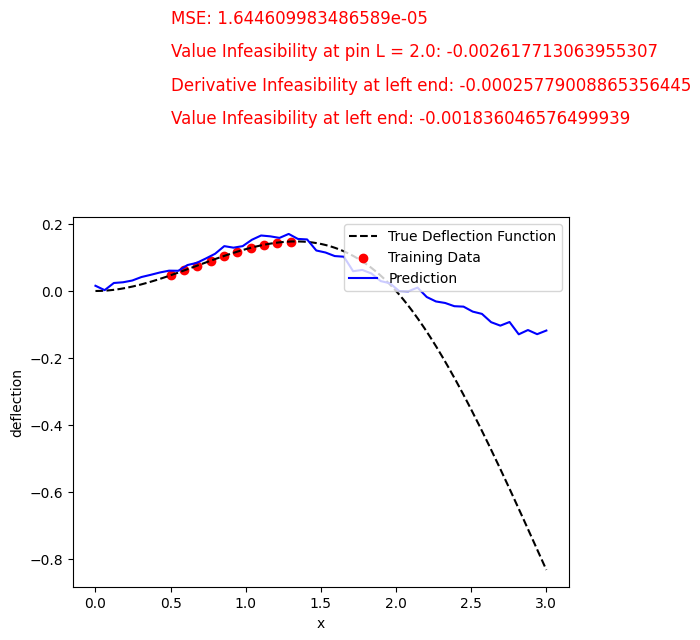

Best model saved at epoch 1601
Best model saved at epoch 1602
Best model saved at epoch 1603
Best model saved at epoch 1604
Best model saved at epoch 1605
Best model saved at epoch 1606
Best model saved at epoch 1607
Best model saved at epoch 1608
Best model saved at epoch 1609
Best model saved at epoch 1610
Best model saved at epoch 1611
Best model saved at epoch 1612
Best model saved at epoch 1613
Best model saved at epoch 1614
Best model saved at epoch 1615
Best model saved at epoch 1616
Best model saved at epoch 1617
Best model saved at epoch 1618
Best model saved at epoch 1619
Best model saved at epoch 1620
Best model saved at epoch 1621
Best model saved at epoch 1622
Best model saved at epoch 1623
Best model saved at epoch 1624
Best model saved at epoch 1625
Best model saved at epoch 1626
Best model saved at epoch 1627
Best model saved at epoch 1628
Best model saved at epoch 1629
Best model saved at epoch 1630
Best model saved at epoch 1631
Best model saved at epoch 1632
Best mod

In [12]:
best_loss = 1e9
opt_beam_regression = mdmm_module.make_optimizer(beam_regression.parameters(), lr=1e-3)
# scheduler
for epoch in range(10000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints, labels = datapoints.to(device), labels.to(device)
        preds, loss_total, loss_data, loss_complexity = beam_regression.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/x_train.shape[0]
        )
        mdmm_return = mdmm_module(loss_total)
        opt_beam_regression.zero_grad()
        mdmm_return.value.backward()
        opt_beam_regression.step()
        mse_ = mse_loss(preds[0], labels)
        # total_constraint_infeasibility = mdmm_return.infs[0].detach().clone().abs().sum() + mdmm_return.infs[1].detach().clone().abs().sum()
        if mdmm_return.value.item() < best_loss:
            best_model = beam_regression
            print('Best model saved at epoch', epoch)
        
        if epoch % 100 == 0 and i == 0:
            print('Epoch', epoch, 'Loss_total', mdmm_return.value.item(), 'GNLL', loss_data.item(), 'MSE', mse_.item(),'Loss_complexity', loss_complexity.item(), 
                  'Value Infeasibility at left end', mdmm_return.infs[0].item(), 'Derivative Infeasibility at left end', mdmm_return.infs[2].item(), 
                  'Value inf at pin L = 2.0', mdmm_return.infs[1].item())
            
            
            # animate the prediction of the model
            x_pred = np.linspace(0, 3, 50)
            y_pred = np.array([beam_regression(torch.tensor(i).float().view(-1, 1).to(device))[0].detach().cpu().numpy() for i in x_pred])
            y_pred = y_pred.squeeze()
            clear_output(wait=True)
            plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")
            plt.scatter(x_train, y_train, label="Training Data", color="red")
            plt.plot(x_pred, y_pred, label="Prediction", color="blue")
            plt.xlabel("x")
            plt.ylabel("deflection")
            plt.legend(loc = 'upper right')
            # display the constraint infesibility values on the plot
            plt.text(0.5, 0.5, 'Value Infeasibility at left end: ' + str(mdmm_return.infs[0].item()), fontsize=12, color='red')
            plt.text(0.5, 0.6, 'Derivative Infeasibility at left end: ' + str(mdmm_return.infs[2].item()), fontsize=12, color='red')
            plt.text(0.5, 0.7, 'Value Infeasibility at pin L = 2.0: ' + str(mdmm_return.infs[1].item()), fontsize=12, color='red')
            # mse
            plt.text(0.5, 0.8, 'MSE: ' + str(mse_.item()), fontsize=12, color='red')
            # also print the values of the lagrange multipliers
            # plt.text(0.5, 0.8, 'Lagrange Multipliers: ' + str(mdmm_module[0].lmbda, mdmm_module[1].lmbda, mdmm_module[2].lmbda), fontsize=12, color='red')
            
            plt.show()
            
    if mdmm_return.infs[0].abs().item() < 1e-3 and mdmm_return.infs[1].abs().item() < 1e-3 and mdmm_return.infs[2].abs().item() < 1e-3 and mse_.item() < 1e-4:
        print('Constraints satisfied')
        best_model = beam_regression
        # exit the training loop
        break
    
    
            

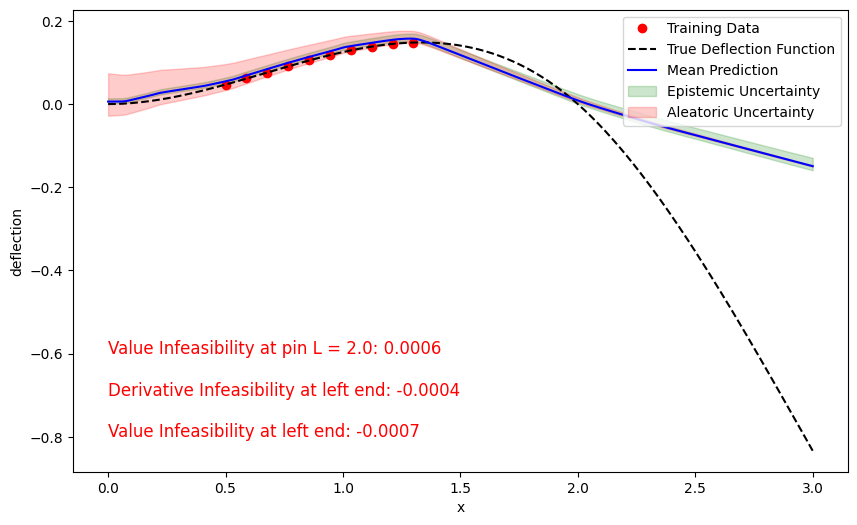

Value Constraint compliance at left end 0.0006696395576000214
Slope Constraint compliance at left end 0.00039830803871154785
Value Constraint compliance at x = 2.0 -0.0006061680614948273


In [13]:
# plotting 
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'ro', label='Training Data')
plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")

x_plot = torch.linspace(0, 3, 300).view(-1, 1).to(device)

with torch.no_grad():
    preds = [best_model(x_plot)[0].cpu().detach().numpy() for _ in range(100)]
    preds = np.stack(preds)
    mean = np.mean(preds, axis=0)
    std = np.std(preds, axis=0)
    ale = best_model(x_plot)[1].cpu().detach().numpy()
    ale = ale**0.5
    plt.plot(x_plot.squeeze().cpu().numpy(), mean, label="Mean Prediction", color="blue")
    plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - std.squeeze(), mean.squeeze() + 2*std.squeeze(), color="green", alpha=0.2, label="Epistemic Uncertainty")
    plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - ale.squeeze(), mean.squeeze() + 2*ale.squeeze(), color="red", alpha=0.2, label="Aleatoric Uncertainty")
    plt.xlabel("x")
    plt.ylabel("deflection")
    plt.legend(loc = 'upper right')
    # display the constraint infesibility values on the plot rounded to 3 decimal places
    plt.text(0.0, -0.8, 'Value Infeasibility at left end: ' + str(round(mdmm_return.infs[0].item(), 4)), fontsize=12, color='red'
                )
    plt.text(0.0, -0.7, 'Derivative Infeasibility at left end: ' + str(round(mdmm_return.infs[2].item(), 4)), fontsize=12, color='red'
                )
    plt.text(0.0, -0.6, 'Value Infeasibility at pin L = 2.0: ' + str(round(mdmm_return.infs[1].item(), 4)), fontsize=12, color='red'
                )
    
    # text size
plt.rcParams.update({'font.size': 10})

plt.show()

print('Value Constraint compliance at left end', (mdmm_return.fn_values[0] - y_value[0]).item())
print('Slope Constraint compliance at left end', (mdmm_return.fn_values[2] - y_derivative[0]).item())
print('Value Constraint compliance at x = 2.0', (mdmm_return.fn_values[1] - y_value[1]).item())


In [20]:
x_train = np.linspace(0.5, 1.3, 10)
y_train = np.array([deflection_noise(i) for i in x_train])

x_train_additional = np.linspace(2.75, 3, 3)
y_train_additional = np.array([deflection_noise(i) for i in x_train_additional])

x_train = np.concatenate((x_train, x_train_additional))
y_train = np.concatenate((y_train, y_train_additional))

ds_train = torch.utils.data.TensorDataset(torch.tensor(x_train).float().view(-1, 1), torch.tensor(y_train).float().view(-1, 1))
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=13, shuffle=True)


In [21]:
def derivative_constraint_fn(*args, **kwargs):
    
	pred = beam_regression(x_derivative)[0]
	d_pred = (pred[1] - pred[0])/(2*0.05)
	return d_pred.squeeze()

def value_constraint_fn_1(*args, **kwargs):
    pred = beam_regression(x_value_0)[0]
    return pred.squeeze()

def value_constraint_fn_2(*args, **kwargs):
    pred = beam_regression(x_value_1)[0]
    return pred.squeeze()


x_derivative = torch.tensor([[0.0], [0.05]]).float().to(device)
y_derivative = torch.tensor([0.0]).float().to(device)

x_value = torch.tensor([[0.0], [2.0]]).float().to(device)
y_value = torch.tensor([[0.0], [0.0]]).float().to(device)

# separate the two value constraints
x_value_0 = torch.tensor([[0.0]]).float().to(device)
y_value_0 = torch.tensor([0.0]).float().to(device)
x_value_1 = torch.tensor([[2.0]]).float().to(device)
y_value_1 = torch.tensor([0.0]).float().to(device)


value_constraint_1 = mdmm.EqConstraint(value_constraint_fn_1, y_value_0)
value_constraint_2 = mdmm.EqConstraint(value_constraint_fn_2, y_value_1)
derivative_constraint = mdmm.EqConstraint(derivative_constraint_fn, y_derivative)
mdmm_module = mdmm.MDMM([value_constraint_1, value_constraint_2, derivative_constraint])
criterion = nn.GaussianNLLLoss()
mse_loss = nn.MSELoss(reduce = 'sum')

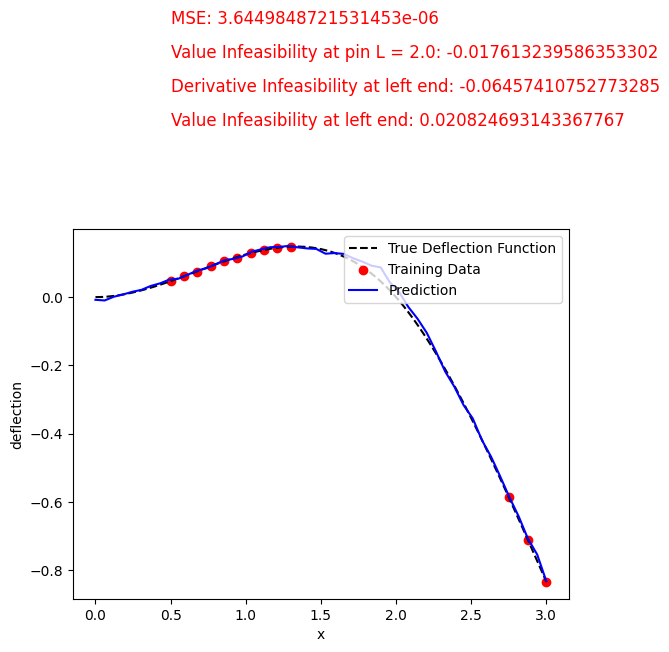

Best model saved at epoch 19901
Best model saved at epoch 19902
Best model saved at epoch 19903
Best model saved at epoch 19904
Best model saved at epoch 19905
Best model saved at epoch 19906
Best model saved at epoch 19907
Best model saved at epoch 19908
Best model saved at epoch 19909
Best model saved at epoch 19910
Best model saved at epoch 19911
Best model saved at epoch 19912
Best model saved at epoch 19913
Best model saved at epoch 19914
Best model saved at epoch 19915
Best model saved at epoch 19916
Best model saved at epoch 19917
Best model saved at epoch 19918
Best model saved at epoch 19919
Best model saved at epoch 19920
Best model saved at epoch 19921
Best model saved at epoch 19922
Best model saved at epoch 19923
Best model saved at epoch 19924
Best model saved at epoch 19925
Best model saved at epoch 19926
Best model saved at epoch 19927
Best model saved at epoch 19928
Best model saved at epoch 19929
Best model saved at epoch 19930
Best model saved at epoch 19931
Best mod

In [27]:
best_loss = 1e9
data_loss_history = []
mse_risk = nn.MSELoss(reduction='sum')
mdmm_module.make_optimizer(beam_regression.parameters(), lr=1e-2)
for epoch in range(20000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints, labels = datapoints.to(device), labels.to(device)
        preds, loss_total, loss_data, loss_complexity = beam_regression.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/x_train.shape[0]
        )
        data_loss_history.append(loss_data.item())
        mse_loss = mse_risk(beam_regression(datapoints)[0], labels).detach()
        mdmm_return = mdmm_module(loss_total)
        opt_beam_regression.zero_grad()
        mdmm_return.value.backward()
        opt_beam_regression.step()
        if mdmm_return.value.item() < best_loss:
            best_model = beam_regression
            print('Best model saved at epoch', epoch)

        # total_constraint_infeasibility = mdmm_return.infs[0].detach().clone().abs().sum() + mdmm_return.infs[1].detach().clone().abs().sum()
        if epoch % 100 == 0 and i == 0:
            print('Epoch', epoch, 'Loss_total', mdmm_return.value.item(), 'Loss_data', mse_loss.item(), 'Loss_complexity', loss_complexity.item(), 
                  'Value Infeasibility at left end', mdmm_return.infs[0].item(), 'Derivative Infeasibility at left end', mdmm_return.infs[2].item(), 
                  'Value inf at pin L = 2.0', mdmm_return.infs[1].item())
            # animate the prediction of the model
            x_pred = np.linspace(0, 3, 50)
            y_pred = np.array([best_model(torch.tensor(i).float().view(-1, 1).to(device))[0].detach().cpu().numpy() for i in x_pred])
            y_pred = y_pred.squeeze()
            clear_output(wait=True)
            plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")
            plt.scatter(x_train, y_train, label="Training Data", color="red")
            plt.plot(x_pred, y_pred, label="Prediction", color="blue")
            plt.xlabel("x")
            plt.ylabel("deflection")
            plt.legend(loc = 'upper right')
            # display the constraint infesibility values on the plot
            plt.text(0.5, 0.5, 'Value Infeasibility at left end: ' + str(mdmm_return.infs[0].item()), fontsize=12, color='red')
            plt.text(0.5, 0.6, 'Derivative Infeasibility at left end: ' + str(mdmm_return.infs[2].item()), fontsize=12, color='red')
            plt.text(0.5, 0.7, 'Value Infeasibility at pin L = 2.0: ' + str(mdmm_return.infs[1].item()), fontsize=12, color='red')
            # mse
            plt.text(0.5, 0.8, 'MSE: ' + str(mse_.item()), fontsize=12, color='red')
            # also print the values of the lagrange multipliers
            # plt.text(0.5, 0.8, 'Lagrange Multipliers: ' + str(mdmm_module[0].lmbda, mdmm_module[1].lmbda, mdmm_module[2].lmbda), fontsize=12, color='red')
            
            plt.show()

    # if epoch % 25 == 0:
    #     # compute the variance of the data loss over the past 25 epochs
    #     data_loss_variance = np.var(data_loss_history[-25:])
    if mdmm_return.infs[0].abs().item() < 5e-3 and mdmm_return.infs[1].abs().item() < 5e-3 and mdmm_return.infs[2].abs().item() < 5e-3 \
    and mse_loss.item() < 1e-3:
        print('Constraints satisfied: Value Infeasibility at left end', mdmm_return.infs[0][0].item(), 'Derivative Infeasibility at left end', mdmm_return.infs[1].item(), 
              'Value inf at pin L = 2.0', mdmm_return.infs[0][1].item(), 'MSE Loss', mse_loss.item())
        best_model = beam_regression
        # exit the training loop
        break

    
            

In [28]:
unconstrained_model = UniformPriorHeteroscedasticRegressor(1, 2).to(device)
opt_unconstrained = optim.Adam(unconstrained_model.parameters(), lr=1e-4)
criterion = nn.GaussianNLLLoss()
best_loss = 1e9
for epoch in range(20000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints, labels = datapoints.to(device), labels.to(device)
        _, loss_total, loss_data, loss_complexity = unconstrained_model.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/x_train.shape[0]
        )
        mse_loss = mse_risk(unconstrained_model(datapoints)[0], labels).detach()
        opt_unconstrained.zero_grad()
        loss_total.backward()
        opt_unconstrained.step()
        if loss_total.item() < best_loss:
            best_loss = loss_total.item()
            best_model_unconstrained = unconstrained_model
            print('Best model saved at epoch', epoch)
        
        if i % 10 == 0:
            print('Epoch', epoch, 'Loss_total', loss_total.item(), 'Loss_data', loss_data.item(), 'Loss_complexity', loss_complexity.item())
    if mse_loss.item() < 1e-3:
        print('Constraints satisfied')
        best_model = unconstrained_model
        # exit the training loop
        break

Best model saved at epoch 0
Epoch 0 Loss_total 3552061.5 Loss_data 0.19298022985458374 Loss_complexity 3552061.25
Epoch 1 Loss_total 3552092.75 Loss_data 0.05018148571252823 Loss_complexity 3552092.75
Best model saved at epoch 2
Epoch 2 Loss_total 3551887.0 Loss_data -0.049328047782182693 Loss_complexity 3551887.0
Best model saved at epoch 3
Epoch 3 Loss_total 3551870.0 Loss_data -0.40197959542274475 Loss_complexity 3551870.5
Epoch 4 Loss_total 3552026.5 Loss_data -0.3816499710083008 Loss_complexity 3552027.0
Epoch 5 Loss_total 3552067.25 Loss_data -0.5171943306922913 Loss_complexity 3552067.75
Best model saved at epoch 6
Epoch 6 Loss_total 3551830.0 Loss_data -0.8847554326057434 Loss_complexity 3551831.0
Epoch 7 Loss_total 3552003.5 Loss_data -0.6963562965393066 Loss_complexity 3552004.25
Epoch 8 Loss_total 3551913.25 Loss_data -1.2891556024551392 Loss_complexity 3551914.5
Epoch 9 Loss_total 3551998.25 Loss_data -0.768828809261322 Loss_complexity 3551999.0
Epoch 10 Loss_total 3552057.

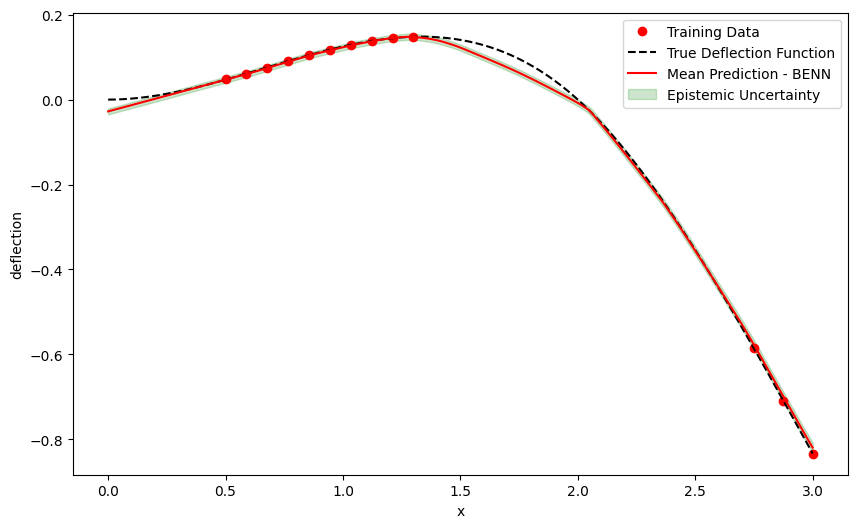

In [25]:
# plotting 
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'ro', label='Training Data')
plt.plot(x_true, y_true, label="True Deflection Function", color="black", linestyle="--")

x_plot = torch.linspace(0, 3, 300).view(-1, 1).to(device)

with torch.no_grad():
    preds = [best_model(x_plot)[0].cpu().detach().numpy() for _ in range(100)]
    preds = np.stack(preds)
    mean = np.mean(preds, axis=0)
    std = np.std(preds, axis=0)
    ale = best_model(x_plot)[1].cpu().detach().numpy()
    ale = ale**0.5
    
    # preds_unconstrained = [best_model_unconstrained(x_plot)[0].cpu().detach().numpy() for _ in range(100)]
    # preds_unconstrained = np.stack(preds_unconstrained)
    # mean_unconstrained = np.mean(preds_unconstrained, axis=0)
    # std_unconstrained = np.std(preds_unconstrained, axis=0)
    # ale_unconstrained = unconstrained_model(x_plot)[1].cpu().detach().numpy()
    # ale_unconstrained = ale_unconstrained**0.5
    
    # plt.plot(x_plot.squeeze().cpu().numpy(), mean_unconstrained, label="Mean Prediction - BNN", color="blue")
    plt.plot(x_plot.squeeze().cpu().numpy(), mean, label="Mean Prediction - BENN", color="red")
    # plt.fill_between(x_plot.squeeze().cpu().numpy(), mean_unconstrained.squeeze() - 2*std_unconstrained.squeeze(), mean_unconstrained.squeeze() + 2*std_unconstrained.squeeze(), color="green", alpha=0.2, label="Epistemic Uncertainty - BNN")
    plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - 2*std.squeeze(), mean.squeeze() + 2*std.squeeze(), color="green", alpha=0.2, label="Epistemic Uncertainty")
    # plt.fill_between(x_plot.squeeze().cpu().numpy(), mean.squeeze() - 2*ale.squeeze(), mean.squeeze() + 2*ale.squeeze(), color="red", alpha=0.2, label="Aleatoric Uncertainty")
    plt.xlabel("x")
    plt.ylabel("deflection")
    plt.legend(loc = 'upper right')
    
    
plt.show()
    